In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Stats & Utilities
from scipy.stats import zscore, entropy, kurtosis
import networkx as nx
from itertools import product
from joblib import Parallel, delayed
from sklearn.utils import resample
from IPython.display import display

# Preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OrdinalEncoder, RobustScaler, MaxAbsScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.neighbors import kneighbors_graph, NearestNeighbors

# Clustering
import hdbscan
from sklearn.cluster import KMeans, Birch, MiniBatchKMeans, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from hdbscan.validity import validity_index
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist, squareform

# Dimensionality Reduction
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#External Tests
from diptest import diptest

C:\Users\Eden Thomas\.conda\envs\thesis\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Plotting Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
# Load Dataset
file_path = "./Data/telecom_preprocessed.csv"
df = pd.read_csv(file_path)

# Best Parameter Identification

In [4]:
X = df.values

In [5]:
pca = PCA()
X_pca_full = pca.fit_transform(X)

print(f"PCA reduced shape: {X_pca_full.shape}")

PCA reduced shape: (100000, 97)


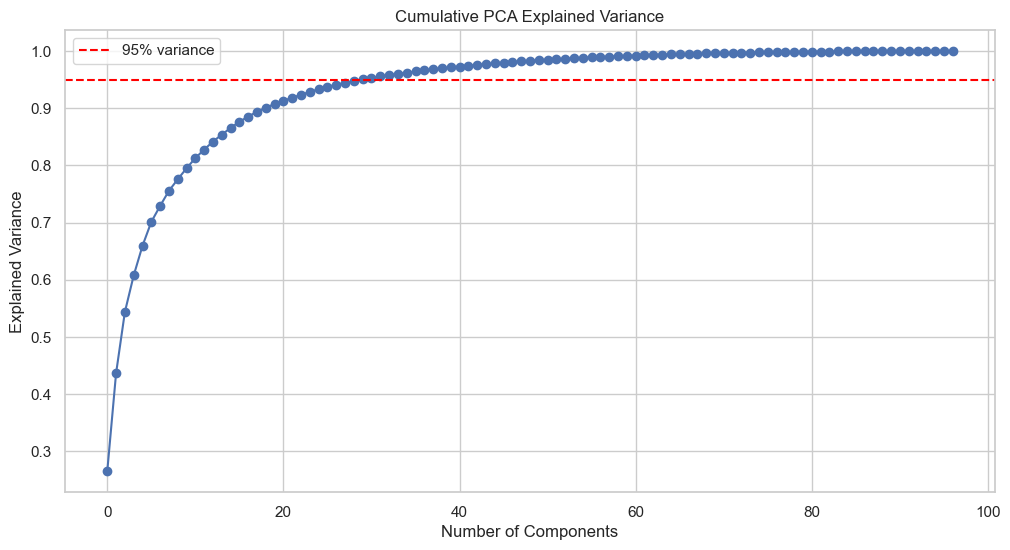

Intrinsic dimensionality for 95% variance: 30 components


In [6]:
pca = PCA().fit(X)
explained = np.cumsum(pca.explained_variance_ratio_)
dim_95 = int(np.argmax(explained >= 0.95) + 1)

# Plot
plt.plot(explained, marker='o')
plt.axhline(0.95, color='red', linestyle='--', label='95% variance')
plt.title("Cumulative PCA Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.legend()
plt.show()

print(f"Intrinsic dimensionality for 95% variance: {dim_95} components")

In [7]:
pca_final = PCA(n_components=30, random_state=42)
X_pca = pca_final.fit_transform(X)

print(f"PCA reduced shape: {X_pca.shape}")

PCA reduced shape: (100000, 30)


In [11]:
X = X_pca
print(X.shape)

(100000, 30)


### KMEANS

In [12]:
k_values = range(2, 11)

# Store results
results = []

# Loop over k values
for k in k_values:
    try:
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = km.fit_predict(X)

        # Compute clustering metrics
        sil = silhouette_score(X, labels)
        dbi = davies_bouldin_score(X, labels)
        chi = calinski_harabasz_score(X, labels)

        # Store the results
        results.append({
            "k": k,
            "silhouette": sil,
            "dbi": dbi,
            "chi": chi
        })

        # Print live progress
        print(f"Done: k={k}, silhouette={sil:.3f}, dbi={dbi:.3f}, chi={chi:.1f}")

    except Exception as e:
        print(f"Error at k={k}: {e}")

# Final DataFrame
df_kmeans_results = pd.DataFrame(results).sort_values(by="silhouette", ascending=False).reset_index(drop=True)
display(df_kmeans_results)

Done: k=2, silhouette=0.373, dbi=1.045, chi=24446.4
Done: k=3, silhouette=0.406, dbi=1.172, chi=32291.5
Done: k=4, silhouette=0.147, dbi=1.798, chi=25873.1
Done: k=5, silhouette=0.171, dbi=1.665, chi=21937.3
Done: k=6, silhouette=0.196, dbi=1.497, chi=20871.1
Done: k=7, silhouette=0.197, dbi=1.498, chi=19230.6
Done: k=8, silhouette=0.205, dbi=1.414, chi=18487.6
Done: k=9, silhouette=0.170, dbi=1.537, chi=17224.0
Done: k=10, silhouette=0.169, dbi=1.528, chi=15666.1


,k,silhouette,dbi,chi
0,3,0.405979,1.171774,32291.534100
1,2,0.372546,1.045070,24446.378068
2,8,0.204937,1.414289,18487.572498
3,7,0.196611,1.497538,19230.578670
4,6,0.196127,1.496905,20871.124992
5,5,0.170530,1.665062,21937.283088
6,9,0.170028,1.537123,17223.966415
7,10,0.168572,1.528008,15666.058540
8,4,0.147372,1.798103,25873.061830


### GMM

In [13]:
# k values to test
k_values = range(2, 11)

# Store results
results = []

# Loop over k values
for k in k_values:
    try:
        gmm = GaussianMixture(n_components=k, random_state=42)
        labels = gmm.fit_predict(X)

        # Compute clustering metrics
        sil = silhouette_score(X, labels)
        dbi = davies_bouldin_score(X, labels)
        chi = calinski_harabasz_score(X, labels)

        # Store result
        results.append({
            "k": k,
            "silhouette": sil,
            "dbi": dbi,
            "chi": chi
        })

        # Print live progress
        print(f"Done: k={k}, silhouette={sil:.3f}, dbi={dbi:.3f}, chi={chi:.1f}")

    except Exception as e:
        print(f"Error at k={k}: {e}")

# Final DataFrame
df_gmm_results = pd.DataFrame(results).sort_values(by="silhouette", ascending=False).reset_index(drop=True)
display(df_gmm_results)

Done: k=2, silhouette=0.372, dbi=1.462, chi=25245.6
Done: k=3, silhouette=0.283, dbi=1.513, chi=26350.0
Done: k=4, silhouette=0.267, dbi=2.655, chi=21197.7
Done: k=5, silhouette=0.154, dbi=2.563, chi=18242.8
Done: k=6, silhouette=0.182, dbi=2.335, chi=17544.2
Done: k=7, silhouette=0.175, dbi=2.233, chi=16216.9
Done: k=8, silhouette=0.161, dbi=2.305, chi=14239.3
Done: k=9, silhouette=0.174, dbi=2.413, chi=13098.8
Done: k=10, silhouette=0.172, dbi=2.749, chi=11575.3


,k,silhouette,dbi,chi
0,2,0.372292,1.461953,25245.589940
1,3,0.282616,1.512973,26350.033391
2,4,0.267114,2.654521,21197.685143
3,6,0.182369,2.335056,17544.234200
4,7,0.175102,2.233066,16216.919883
5,9,0.174113,2.412754,13098.831553
6,10,0.171681,2.748864,11575.260863
7,8,0.161279,2.304721,14239.278683
8,5,0.153587,2.562880,18242.794013


### BIRCH

In [14]:
# Manual threshold input
BIRCH_THRESHOLD = 5

# Run BIRCH
birch = Birch(n_clusters=None, threshold=BIRCH_THRESHOLD)
labels_birch = birch.fit_predict(X)
subcentres = birch.subcluster_centers_
n_sub = subcentres.shape[0]

print(f"Birch threshold={BIRCH_THRESHOLD} produced {n_sub} subclusters.\n")

Birch threshold=5 produced 2667 subclusters.



In [15]:
# KMeans on BIRCH subcluster centers
results = []
k_values = range(2, 11)

for k in k_values:
    try:
        km = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = km.fit_predict(subcentres)

        sil = silhouette_score(subcentres, labels)
        dbi = davies_bouldin_score(subcentres, labels)
        chi = calinski_harabasz_score(subcentres, labels)

        results.append({
            "k": k,
            "silhouette": sil,
            "dbi": dbi,
            "chi": chi
        })

        print(f"KMeans on subclusters: k={k}, silhouette={sil:.3f}, dbi={dbi:.3f}, chi={chi:.1f}")
    
    except Exception as e:
        print(f"Error at k={k}: {e}")

# Final table
df_birch_results = pd.DataFrame(results).sort_values(by="silhouette", ascending=False).reset_index(drop=True)
display(df_birch_results)

KMeans on subclusters: k=2, silhouette=0.188, dbi=1.911, chi=625.5
KMeans on subclusters: k=3, silhouette=0.141, dbi=2.066, chi=484.6
KMeans on subclusters: k=4, silhouette=0.137, dbi=2.004, chi=437.2
KMeans on subclusters: k=5, silhouette=0.126, dbi=2.083, chi=377.5
KMeans on subclusters: k=6, silhouette=0.124, dbi=2.121, chi=355.9
KMeans on subclusters: k=7, silhouette=0.121, dbi=2.087, chi=320.6
KMeans on subclusters: k=8, silhouette=0.130, dbi=1.930, chi=307.4
KMeans on subclusters: k=9, silhouette=0.125, dbi=1.904, chi=286.6
KMeans on subclusters: k=10, silhouette=0.129, dbi=1.876, chi=270.6


,k,silhouette,dbi,chi
0,2,0.187729,1.910535,625.523102
1,3,0.141365,2.065604,484.621492
2,4,0.137226,2.003863,437.222708
3,8,0.129686,1.929761,307.434851
4,10,0.129166,1.876304,270.641563
5,5,0.125569,2.083414,377.452676
6,9,0.124799,1.904180,286.575583
7,6,0.123952,2.120809,355.876189
8,7,0.120870,2.087062,320.566969


### HDBSCAN

In [17]:
# CONFIG
SAMPLE_SIZE = 50_000            # 35_000 rows from 100_000
RANDOM_STATE = 42             # for reproducibility
N_JOBS = -1                 # use all cores

# Parameter grid
param_grid = {
    "min_cluster_size": [250,300, 350, 400, 450, 500, 550, 600, 650,700,750,800],
    "min_samples": [None],
}

#Sample for preliminary analysis
if X.shape[0] > SAMPLE_SIZE:
    rng = np.random.default_rng(42)
    sample_idx = rng.choice(X.shape[0], SAMPLE_SIZE, replace=False)
    Xs = X[sample_idx]
else:
    Xs = X

# Define function to run one HDBSCAN fit
def run_hdbscan(mcs, ms):
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=mcs,
        min_samples=ms,
        metric="euclidean",
        core_dist_n_jobs=-1,
        approx_min_span_tree=True,
        prediction_data=False,
    )
    labels = hdb.fit_predict(Xs)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    # Quality scores
    sil = (silhouette_score(Xs, labels) if n_clusters >= 2 else np.nan)
    mask = labels != -1
    if mask.sum() >= 2 and len(np.unique(labels[mask])) >= 2:
        dbi = davies_bouldin_score(Xs[mask], labels[mask])
        chi = calinski_harabasz_score(Xs[mask], labels[mask])
    else:
        dbi, chi = np.nan, np.nan

    return {
        "min_cluster_size": mcs,
        "min_samples": ms,
        "k": n_clusters,
        "silhouette": sil,
        "dbi": dbi,
        "chi": chi,
    }

# Grid Search
combos = [(mcs, ms) for mcs in param_grid["min_cluster_size"] 
                     for ms  in param_grid["min_samples"]]

# Run HDBSCAN for each combination
results = [run_hdbscan(mcs, ms) for mcs, ms in combos]

# Results
df = pd.DataFrame(results)
display(df)

C:\Users\Eden Thomas\.conda\envs\thesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Eden Thomas\.conda\envs\thesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Eden Thomas\.conda\envs\thesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Eden Thomas\.conda\envs\thesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Eden Thomas\.conda\envs\thesis\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure

,min_cluster_size,min_samples,k,silhouette,dbi,chi
0,250,None,6,0.139653,1.134952,8495.563535
1,300,None,6,0.131540,1.109296,8622.131568
2,350,None,5,0.123262,1.102906,10738.830865
3,400,None,4,0.244675,0.958547,13822.075318
4,450,None,4,0.240788,0.952522,13917.696494
5,500,None,4,0.236020,0.945231,13888.698650
6,550,None,4,0.231934,0.939084,13918.029880
7,600,None,4,0.228205,0.933546,13976.270594
8,650,None,4,0.225215,0.928647,14077.243419
9,700,None,4,0.222478,0.923219,14155.201322
